In [1]:
# Get the data for expeirment
import sklearn
import pandas as pd 
import numpy as np

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import explained_variance_score, mean_squared_error
from scipy.spatial.distance import cdist
from numpy.linalg import pinv
from math import sqrt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import geopy.distance as distance
from sklearn.preprocessing import MinMaxScaler

import Data_utils
import matplotlib.ticker as ticker
from functools import reduce
from collections import Counter

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import r2_score

import plotly.express as px
import TsModel
from sklearn.utils import validation
from windrose import WindroseAxes

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
data = pd.read_csv(f'Data\processed_ab_no_precp_train.txt', encoding = "ISO-8859-1")

C:\Users\PPL\AppData\Local\Temp\ipykernel_20152\1202334641.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(f'Data\processed_ab_no_precp_train.txt', encoding = "ISO-8859-1")


In [4]:
data[data['name']=='LLOYDMINSTER'][0:200]

longitude  latitude          name       id              date  temp  \
80145    -110.07     53.31  LLOYDMINSTER  3013959  2012-07-09 17:00  28.2   
80146    -110.07     53.31  LLOYDMINSTER  3013959  2012-07-09 18:00  27.4   
80147    -110.07     53.31  LLOYDMINSTER  3013959  2012-07-09 19:00  25.7   
80148    -110.07     53.31  LLOYDMINSTER  3013959  2012-07-10 10:00  28.2   
80149    -110.07     53.31  LLOYDMINSTER  3013959  2012-07-10 11:00  27.5   
...          ...       ...           ...      ...               ...   ...   
80340    -110.07     53.31  LLOYDMINSTER  3013959  2012-08-11 15:00  21.7   
80341    -110.07     53.31  LLOYDMINSTER  3013959  2012-08-11 16:00  21.1   
80342    -110.07     53.31  LLOYDMINSTER  3013959  2012-08-12 11:00  19.0   
80343    -110.07     53.31  LLOYDMINSTER  3013959  2012-08-12 12:00  20.2   
80344    -110.07     53.31  LLOYDMINSTER  3013959  2012-08-12 13:00  20.8   

       wind_direction  wind_speed  
80145            12.0        17.0  
80146            13.0        11.0  
80147            14.0        18.0  
80148            14.0        11.0  
80149            16.0        13.0  
...               ...         ...  
80340            31.0        21.0  
80341            30.0        18.0  
80342            29.0        15.0  
80343            30.0        15.0  
80344            32.0        15.0  

[200 rows x 8 columns]

In [21]:
data[data['name']=='VEGREVILLE']['wind_direction'][800:1000]

134375    34.0
134376    36.0
134377    14.0
134378    13.0
134379    11.0
          ... 
134570    34.0
134571     8.0
134572     2.0
134573    34.0
134574    32.0
Name: wind_direction, Length: 200, dtype: float64

In [22]:
np.corrcoef(data[data['name']=='VEGREVILLE']['wind_direction'], data[data['name']=='LLOYDMINSTER']['wind_direction'])

array([[1.        , 0.58217497],
       [0.58217497, 1.        ]])

In [23]:
plt.rcParams.update({'font.size': 16})

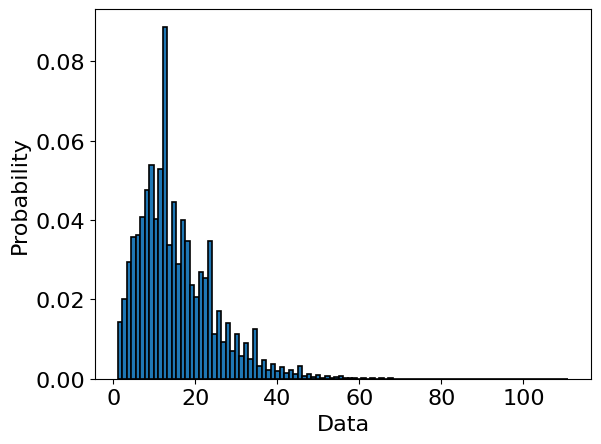

In [24]:
plt.hist(data['wind_speed'], density=True, bins=100,edgecolor='black', linewidth=1.2)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

In [9]:
np.mean(data['wind_speed'])

15.37476885644769

In [10]:
np.max(data['wind_speed'])

111.0

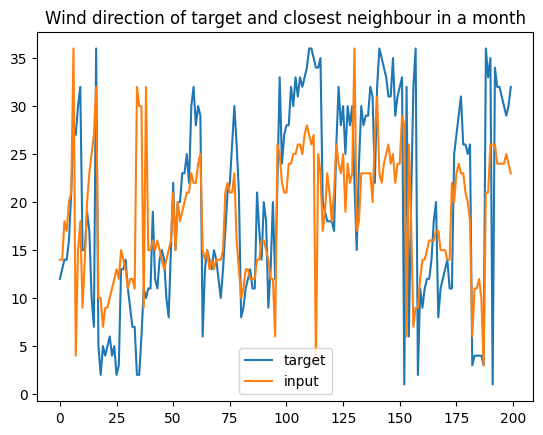

In [159]:
# neightbour wind direction vs target wind direction
plt.plot(range(0,200), data[data['name']=='LLOYDMINSTER']['wind_direction'][0:200], label='target')
plt.plot(range(0,200), data[data['name']=='VEGREVILLE']['wind_direction'][0:200], label='input')
plt.title('Wind direction of target and closest neighbour in a month')
plt.legend()
plt.show()

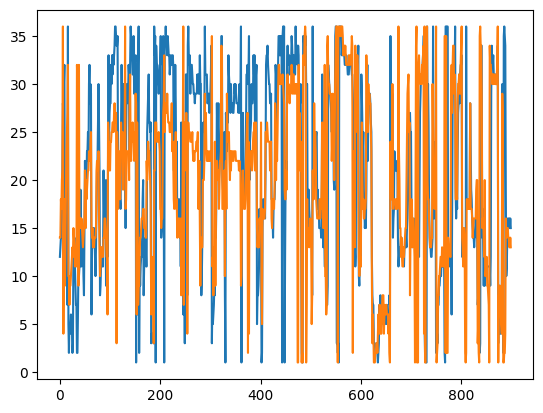

In [138]:
# neightbour wind direction vs target wind direction
plt.plot(range(0, 900), data[data['name']=='LLOYDMINSTER']['wind_direction'][0:900])
plt.plot(range(0, 900), data[data['name']=='VEGREVILLE']['wind_direction'][0:900])
plt.show()

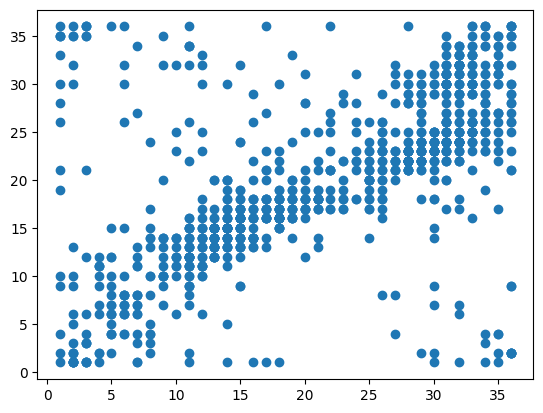

In [137]:
# neightbour wind direction vs target wind direction
plt.scatter(x=data[data['name']=='LLOYDMINSTER']['wind_direction'][0:900], y=data[data['name']=='VEGREVILLE']['wind_direction'][0:900])
plt.show()

In [6]:
# Import the data to plot
plot_data = pd.read_csv('Data/exp/1113_multi_target_no_season/multi_1x.csv', index_col=0)
plot_data_y = pd.read_csv('Data/exp/1113_multi_target_no_season/multi_1y.csv', index_col=0)

In [5]:
plot_data_y

0     1
0       11.0  23.0
1        6.0  28.0
2        6.0   6.0
3       19.0  27.0
4       19.0  28.0
...      ...   ...
534295   4.0  21.0
534296   1.0   3.0
534297   7.0  24.0
534298   3.0  23.0
534299   2.0  15.0

[534300 rows x 2 columns]

In [6]:
# Each station has 26715 records
plot_data[26710:26720]

0       1     2     3     4           5
26710  53.31 -113.58   5.2  26.0  18.0   58.472577
26711  53.31 -113.58   5.8  27.0  13.0   58.472577
26712  53.31 -113.58  15.9  33.0   9.0   58.472577
26713  53.31 -113.58  10.6  25.0   4.0   58.472577
26714  53.31 -113.58   7.0  20.0   8.0   58.472577
26715  51.45 -112.68  33.2  24.0   9.0  109.408914
26716  51.45 -112.68  32.4  24.0   9.0  109.408914
26717  51.45 -112.68  31.4  22.0   6.0  109.408914
26718  51.45 -112.68  27.3   1.0   6.0  109.408914
26719  51.45 -112.68  30.0   1.0   6.0  109.408914

In [7]:
np.corrcoef(plot_data['3'], plot_data_y['1'])

array([[1.        , 0.50922452],
       [0.50922452, 1.        ]])

In [7]:
plt.rcParams.update({'font.size': 18})


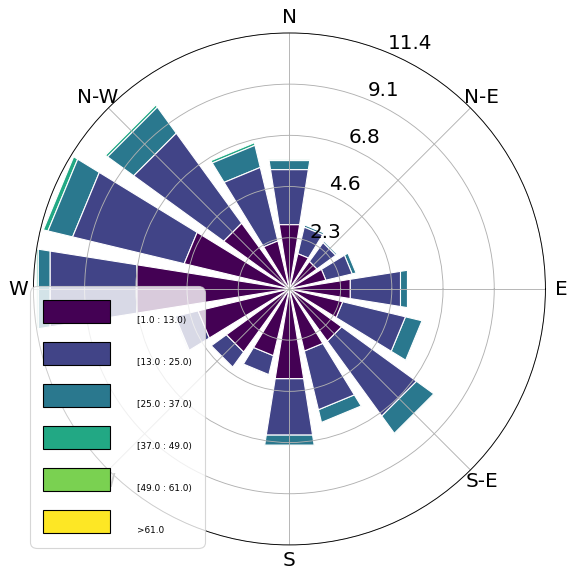

In [8]:
ax = WindroseAxes.from_ax()
ax.bar(plot_data_y['1'][0:26714]*10, plot_data_y['0'][0:26714], normed=True, opening=0.8, edgecolor='white') #
ax.set_legend(fontsize="30")
#ax.set_title('Wind rose for closest neighbour station of the target', fontsize=18)

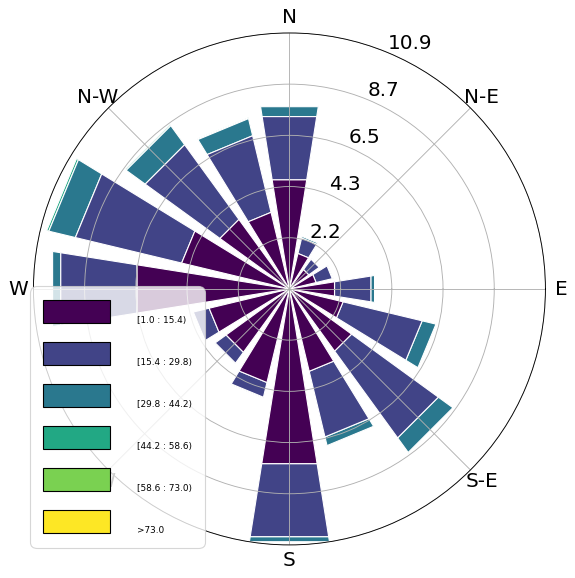

In [9]:
# Modified from source: https://hatarilabs.com/ih-en/how-to-make-a-wind-rose-with-python-tutorial
ax = WindroseAxes.from_ax()
ax.bar(plot_data['3'][0:26714]*10, plot_data['4'][0:26714], normed=True, opening=0.8, edgecolor='white') #[0:26714]
ax.set_legend(fontsize="30")
#ax.set_title('Wind rose of a random target station', fontsize=18)

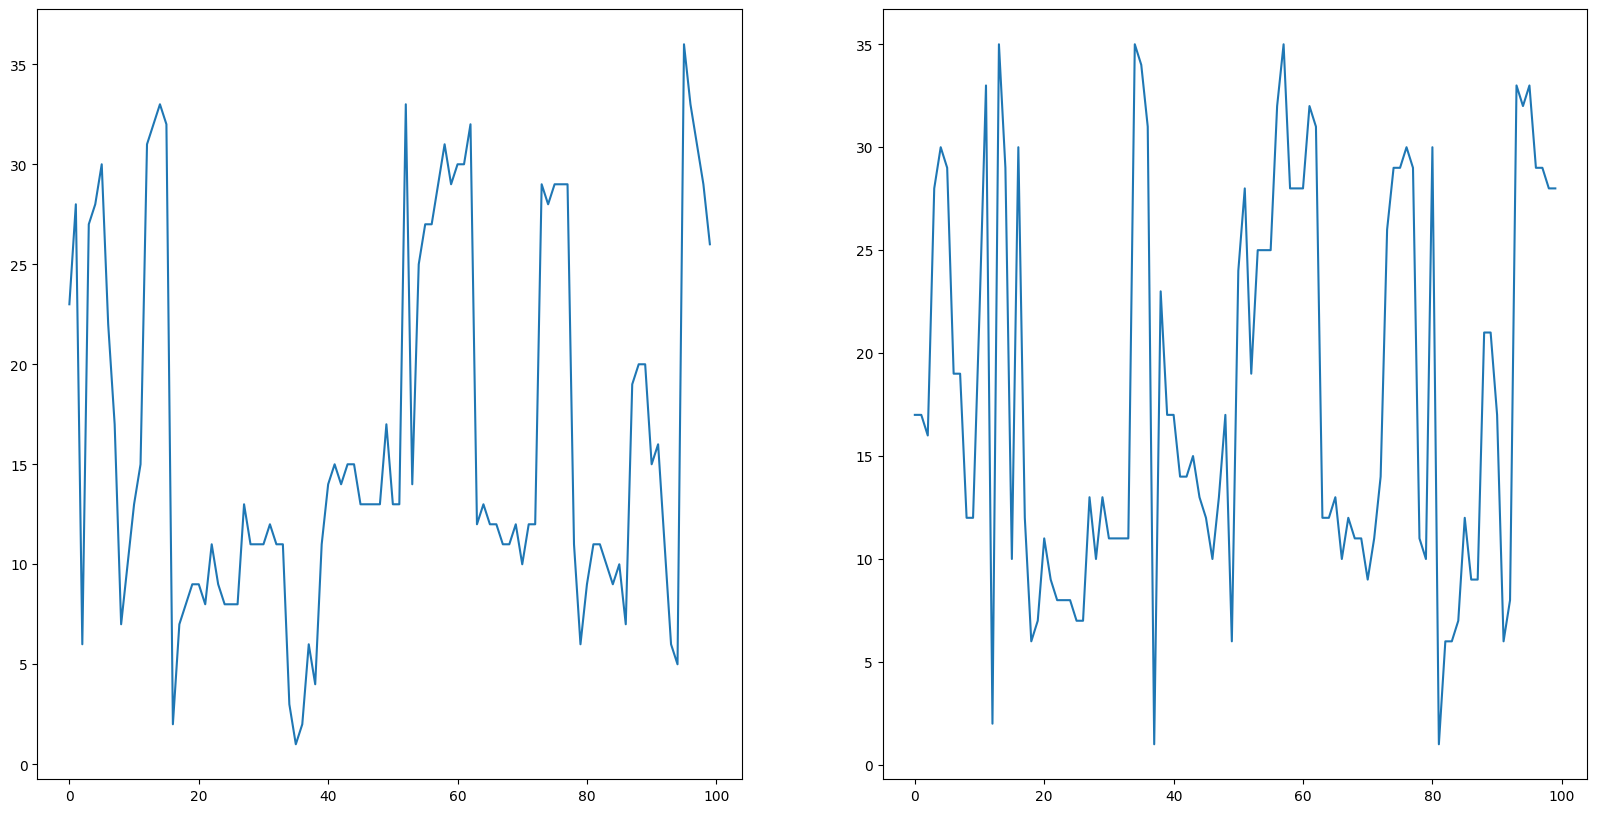

In [64]:
# neightbour wind direction vs target wind direction
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10)) 
ax1.plot(plot_data_y['1'][0:100])
ax2.plot(plot_data['3'][0:100])
plt.show()

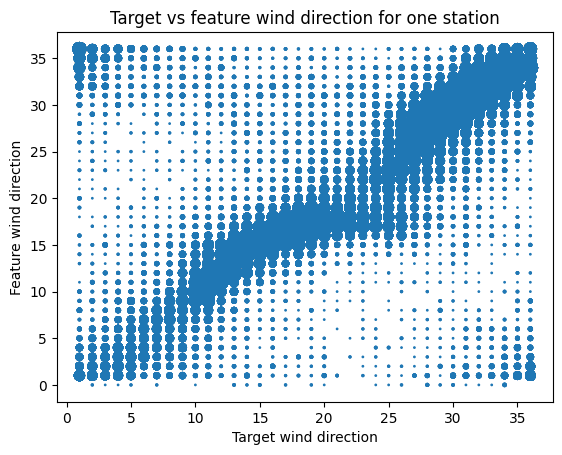

In [195]:
# neightbour wind direction vs target wind direction #[0:900] 
x_vals= np.array(data[data['name']=='LLOYDMINSTER']['wind_direction'])
y_vals= np.array(data[data['name']=='VEGREVILLE']['wind_direction'])
combos = list(zip(x_vals, y_vals))
weight_counter = Counter(combos)
weights = [weight_counter[(x_vals[i], y_vals[i])] for i, _ in enumerate(x_vals)]


plt.scatter(x=x_vals, y=y_vals, s=weights)
plt.xlabel('Target wind direction')
plt.ylabel('Feature wind direction')
plt.title('Target vs feature wind direction for one station')
plt.show()

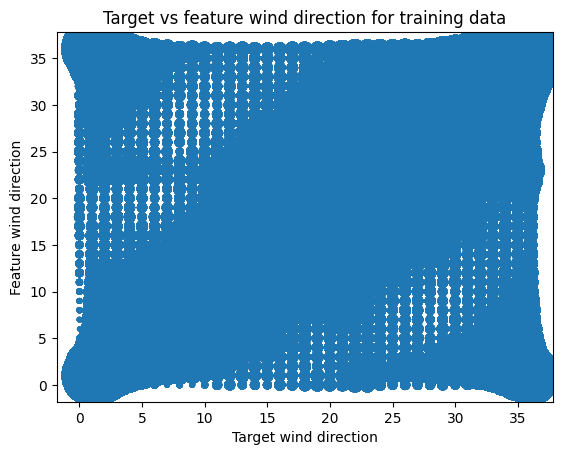

In [197]:
# neightbour wind direction vs target wind direction #[0:900] 
x_vals= np.array(plot_data['3'])
y_vals= np.array(plot_data_y['1'])
combos = list(zip(x_vals, y_vals))
weight_counter = Counter(combos)
weights = [weight_counter[(x_vals[i], y_vals[i])] for i, _ in enumerate(x_vals)]


plt.scatter(x=x_vals, y=y_vals, s=weights)
plt.xlabel('Target wind direction')
plt.ylabel('Feature wind direction')
plt.title('Target vs feature wind direction for training data')
plt.show()

In [20]:
raw_data = pd.read_csv('Data/processed_ab_no_precp_train.txt')


C:\Users\PPL\AppData\Local\Temp\ipykernel_36652\1643415631.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv('Data/processed_ab_no_precp_train.txt')


In [21]:
raw_data

longitude  latitude      name       id              date  temp  \
0         -112.82     53.05   CAMROSE  3011240  2012-07-09 17:00  31.8   
1         -112.82     53.05   CAMROSE  3011240  2012-07-09 18:00  31.2   
2         -112.82     53.05   CAMROSE  3011240  2012-07-09 19:00  30.1   
3         -112.82     53.05   CAMROSE  3011240  2012-07-10 10:00  26.6   
4         -112.82     53.05   CAMROSE  3011240  2012-07-10 11:00  26.1   
...           ...       ...       ...      ...               ...   ...   
534295    -115.55     51.19  BANFF CS  3050519  2023-09-14 06:00   1.9   
534296    -115.55     51.19  BANFF CS  3050519  2023-09-14 07:00   1.4   
534297    -115.55     51.19  BANFF CS  3050519  2023-09-14 18:00  18.4   
534298    -115.55     51.19  BANFF CS  3050519  2023-09-14 19:00  13.7   
534299    -115.55     51.19  BANFF CS  3050519  2023-09-14 20:00  10.4   

        wind_direction  wind_speed  
0                 23.0        11.0  
1                 28.0         6.0  
2                  6.0         6.0  
3                 27.0        19.0  
4                 28.0        19.0  
...                ...         ...  
534295            21.0         4.0  
534296             3.0         1.0  
534297            24.0         7.0  
534298            23.0         3.0  
534299            15.0         2.0  

[534300 rows x 8 columns]

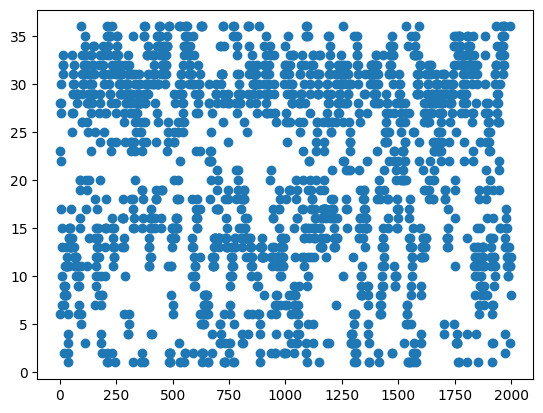

In [22]:
# neightbour wind direction vs target wind direction
combos = list(zip(x_vals, y_vals))
weight_counter = Counter(combos)

weights = [weight_counter[(x_vals[i], y_vals[i])] for i, _ in enumerate(x_vals)]


plt.scatter(x=range(0,2000), y=raw_data['wind_direction'].head(2000), s=weights)
plt.show()

In [27]:
def relu_wrapper(x) :
    return tf.keras.activations.relu(x, max_value=36.0)

In [81]:
def build_neural_network_model():
    model = models.Sequential()
    #model.add(tf.keras.Input(shape=(2,)))
    #model.add(layers.Dense(30, activation=tf.keras.activations.relu))  
    model.add(layers.Dense(10, activation=tf.keras.activations.tanh))    
    model.add(layers.Dense(1, activation=tf.keras.activations.relu))    #relu_wrapper 
    return model

In [177]:
train_x[0:26715]

0       1     2     3     4          5
0      53.31 -113.58  29.9  17.0   7.0  58.472577
1      53.31 -113.58  28.9  17.0   6.0  58.472577
2      53.31 -113.58  27.3  16.0   8.0  58.472577
3      53.31 -113.58  25.2  28.0  13.0  58.472577
4      53.31 -113.58  26.8  30.0  21.0  58.472577
...      ...     ...   ...   ...   ...        ...
26710  53.31 -113.58   5.2  26.0  18.0  58.472577
26711  53.31 -113.58   5.8  27.0  13.0  58.472577
26712  53.31 -113.58  15.9  33.0   9.0  58.472577
26713  53.31 -113.58  10.6  25.0   4.0  58.472577
26714  53.31 -113.58   7.0  20.0   8.0  58.472577

[26715 rows x 6 columns]

In [89]:
#test_data = pd.read_csv('Data\processed_ab_no_precp_test.txt')
train_x = pd.read_csv('Data/exp/multi_1x.csv', index_col=0)
train_y = pd.read_csv('Data/exp/multi_1y.csv', index_col=0)

In [90]:
scaler = StandardScaler()
train_x = train_x['3'][0:26715]#.sample(frac=0.5, random_state=1) 
train_x = np.array(train_x).reshape(-1, 1)
train_x = scaler.fit_transform(train_x)
train_y = train_y['1'][0:26715]

In [91]:
train_x, train_y = shuffle(train_x, train_y)

In [92]:
linear_model = LinearRegression().fit(train_x, train_y)

Text(0.5, 1.0, 'Linear model prediction vs true value for training data')

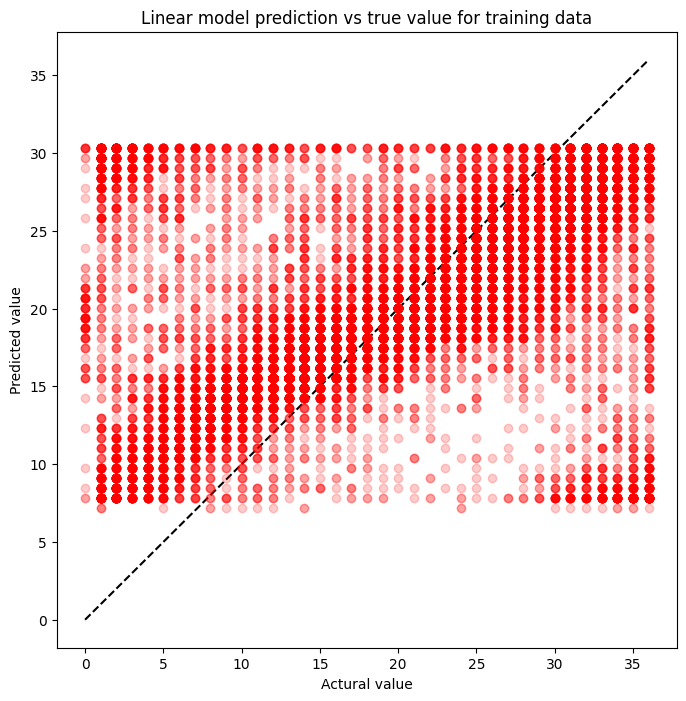

In [67]:
pred = linear_model.predict(train_x)

plt.figure(figsize=(8,8))    
plt.plot([min(train_y),max(train_y)], [min(train_y),max(train_y)], 'k--')
plt.plot(train_y,pred, 'ro', alpha=.2)
plt.xlabel('Actural value')
plt.ylabel('Predicted value')
plt.title('Linear model prediction vs true value for training data')

In [68]:
print(mean_squared_error(pred, train_y, squared=False))

7.632964469923823


In [93]:
# First train the model on the entire training data

# Try different learning rate
# activation function
# try a small NN network
neural_network_model = build_neural_network_model()


neural_network_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError()]
)

history = neural_network_model.fit(
    train_x, 
    train_y, 
    epochs=50, 
    shuffle=True
)

Epoch 1/50
835/835 [==============================] - 2s 2ms/step - loss: 365.2436 - root_mean_squared_error: 19.1113 - mean_absolute_percentage_error: 13879357.0000
Epoch 2/50
835/835 [==============================] - 1s 2ms/step - loss: 123.1264 - root_mean_squared_error: 11.0962 - mean_absolute_percentage_error: 51597024.0000
Epoch 3/50
835/835 [==============================] - 1s 2ms/step - loss: 73.4693 - root_mean_squared_error: 8.5714 - mean_absolute_percentage_error: 68465600.0000
Epoch 4/50
835/835 [==============================] - 1s 2ms/step - loss: 65.9609 - root_mean_squared_error: 8.1216 - mean_absolute_percentage_error: 73296328.0000
Epoch 5/50
835/835 [==============================] - 1s 2ms/step - loss: 60.4809 - root_mean_squared_error: 7.7769 - mean_absolute_percentage_error: 73834312.0000
Epoch 6/50
835/835 [==============================] - 1s 2ms/step - loss: 55.2597 - root_mean_squared_error: 7.4337 - mean_absolute_percentage_error: 72735624.0000
Epoch 7/50
8

Text(0.5, 1.0, 'Loss of neural network')

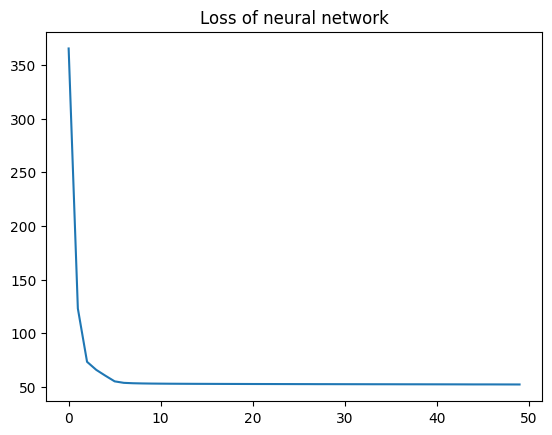

In [94]:
# Include this loss curve in report 

plt.plot(history.history['loss'])
plt.title('Loss of neural network')

835/835 [==============================] - 1s 620us/step


Text(0.5, 1.0, 'Neural network model prediction vs true value for training data')

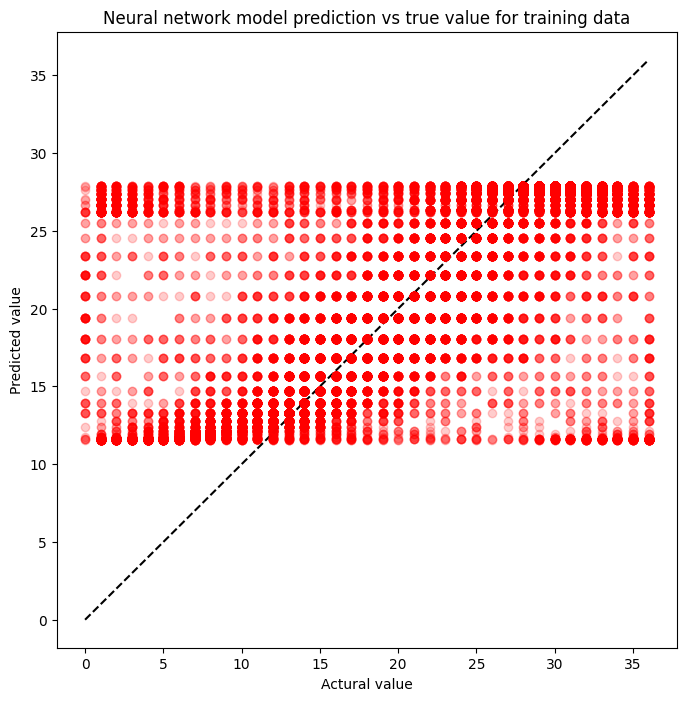

In [95]:
pred = neural_network_model.predict(train_x)

plt.figure(figsize=(8,8))    
plt.plot([min(train_y),max(train_y)], [min(train_y),max(train_y)], 'k--')
plt.plot(train_y, pred, 'ro', alpha=.2)
plt.xlabel('Actural value')
plt.ylabel('Predicted value')
plt.title('Neural network model prediction vs true value for training data')

In [96]:
print(mean_squared_error(train_y, pred, squared=False))

7.233216163641223


In [97]:
def do_exp():
    results = []
    
    for i in range(0, 5):
        neural_network_model = build_neural_network_model()

        neural_network_model.compile(
            optimizer='adam',
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError()]
        )

        history = neural_network_model.fit(
            train_x, 
            train_y, 
            epochs=50, 
            shuffle=True
        )

        pred = neural_network_model.predict(train_x)
        results.append(mean_squared_error(train_y, pred, squared=False))
        print(results[i])

    return results

In [98]:
results = do_exp()

Epoch 1/50
835/835 [==============================] - 1s 1ms/step - loss: 368.5720 - root_mean_squared_error: 19.1982 - mean_absolute_percentage_error: 17457640.0000
Epoch 2/50
835/835 [==============================] - 1s 1ms/step - loss: 117.0487 - root_mean_squared_error: 10.8189 - mean_absolute_percentage_error: 53981608.0000
Epoch 3/50
835/835 [==============================] - 1s 2ms/step - loss: 72.5086 - root_mean_squared_error: 8.5152 - mean_absolute_percentage_error: 68688432.0000
Epoch 4/50
835/835 [==============================] - 1s 1ms/step - loss: 65.2502 - root_mean_squared_error: 8.0778 - mean_absolute_percentage_error: 73478184.0000
Epoch 5/50
835/835 [==============================] - 1s 1ms/step - loss: 58.9368 - root_mean_squared_error: 7.6770 - mean_absolute_percentage_error: 73175280.0000
Epoch 6/50
835/835 [==============================] - 1s 1ms/step - loss: 54.7949 - root_mean_squared_error: 7.4024 - mean_absolute_percentage_error: 72414136.0000
Epoch 7/50
8

835/835 [==============================] - 1s 2ms/step - loss: 51.5661 - root_mean_squared_error: 7.1810 - mean_absolute_percentage_error: 71202224.0000
Epoch 50/50
835/835 [==============================] - 1s 572us/step
7.178655266169156
Epoch 1/50
835/835 [==============================] - 2s 2ms/step - loss: 401.3263 - root_mean_squared_error: 20.0331 - mean_absolute_percentage_error: 15119833.0000
Epoch 2/50
835/835 [==============================] - 1s 2ms/step - loss: 125.1465 - root_mean_squared_error: 11.1869 - mean_absolute_percentage_error: 52278276.0000
Epoch 3/50
835/835 [==============================] - 1s 2ms/step - loss: 72.5895 - root_mean_squared_error: 8.5199 - mean_absolute_percentage_error: 68244936.0000
Epoch 4/50
835/835 [==============================] - 1s 2ms/step - loss: 61.4151 - root_mean_squared_error: 7.8368 - mean_absolute_percentage_error: 72332096.0000
Epoch 5/50
835/835 [==============================] - 1s 2ms/step - loss: 57.3745 - root_mean_square

835/835 [==============================] - 1s 2ms/step - loss: 52.1620 - root_mean_squared_error: 7.2223 - mean_absolute_percentage_error: 70776616.0000
Epoch 48/50
835/835 [==============================] - 1s 1ms/step - loss: 52.1405 - root_mean_squared_error: 7.2208 - mean_absolute_percentage_error: 70746360.0000
Epoch 49/50
835/835 [==============================] - 1s 1ms/step - loss: 52.1135 - root_mean_squared_error: 7.2190 - mean_absolute_percentage_error: 70840632.0000
Epoch 50/50
835/835 [==============================] - 0s 464us/step
7.213846946137338
Epoch 1/50
835/835 [==============================] - 1s 1ms/step - loss: 366.3605 - root_mean_squared_error: 19.1405 - mean_absolute_percentage_error: 16265090.0000
Epoch 2/50
835/835 [==============================] - 1s 2ms/step - loss: 117.1021 - root_mean_squared_error: 10.8214 - mean_absolute_percentage_error: 51539568.0000
Epoch 3/50
835/835 [==============================] - 1s 2ms/step - loss: 72.1088 - root_mean_squa

In [99]:
print(f"{np.mean(results)}±{np.std(results)}")

7.202376390000511±0.01939016237902465


In [31]:
#test_data = pd.read_csv('Data\processed_ab_no_precp_test.txt')
train_x_5 = pd.read_csv('Data/exp/multi_4x.csv', index_col=0)
train_y_5 = pd.read_csv('Data/exp/multi_4y.csv', index_col=0)

In [32]:
scaler = StandardScaler()
train_x_5 = scaler.fit_transform(train_x_5)
train_y_5 = train_y_5['1']

In [33]:
# First train the model on the entire training data

# Try different learning rate
# activation function
# try a small NN network
neural_network_model = build_neural_network_model()


neural_network_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError()]
)

history = neural_network_model.fit(
    train_x_5, 
    np.array(train_y_5), 
    epochs=3, 
    shuffle=True
)

Epoch 1/3
16697/16697 [==============================] - 26s 2ms/step - loss: 73.0575 - root_mean_squared_error: 8.5474 - mean_absolute_percentage_error: 53839160.0000
Epoch 2/3
16697/16697 [==============================] - 25s 2ms/step - loss: 56.5285 - root_mean_squared_error: 7.5185 - mean_absolute_percentage_error: 54556832.0000
Epoch 3/3
16697/16697 [==============================] - 25s 2ms/step - loss: 55.5106 - root_mean_squared_error: 7.4505 - mean_absolute_percentage_error: 54504704.0000


16697/16697 [==============================] - 10s 574us/step


Text(0.5, 1.0, 'Neural network model prediction vs true value for training data')

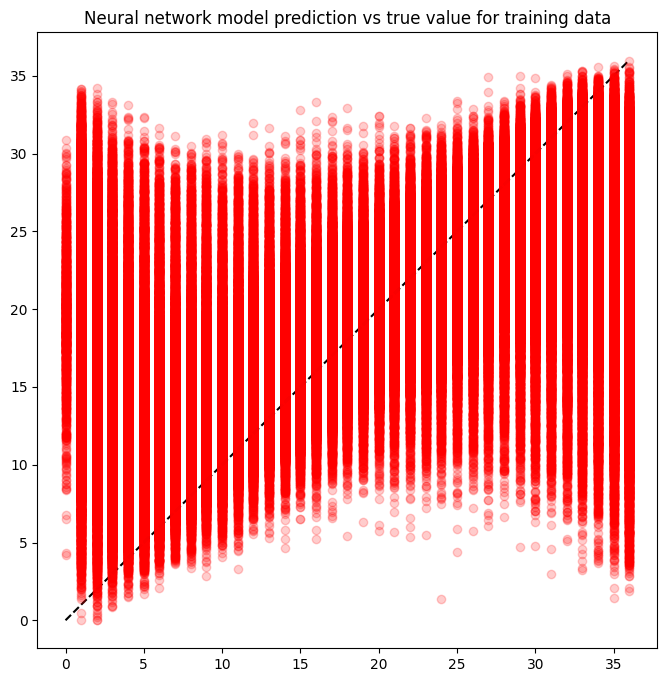

In [34]:
pred = neural_network_model.predict(train_x_5)

plt.figure(figsize=(8,8))    
plt.plot([min(train_y_5),max(train_y_5)], [min(train_y_5),max(train_y_5)], 'k--')
plt.plot(train_y_5, pred, 'ro', alpha=.2)
plt.title('Neural network model prediction vs true value for training data')

In [6]:
# All stations in the dataset
stations_to_test = [
    'LETHBRIDGE CDA',                 
    'EDMONTON STONY PLAIN CS',        
    'CORONATION CLIMATE',             
    'STRATHMORE AGDM',                
    'LLOYDMINSTER',                  
    'MEDICINE HAT RCS',             
    'MILK RIVER',                     
    'CAMROSE',                     
    'BROOKS',                    
    'CLARESHOLM',           
    'ONEFOUR CDA',            
    'VEGREVILLE',             
    'ROCKY MTN HOUSE (AUT)',         
    'LACOMBE CDA 2',              
    'BANFF CS',                     
    'DRUMHELLER EAST',         
    'MEDICINE HAT',                 
    'LETHBRIDGE',                 
    'EDMONTON INTL A',         
    'CALGARY INTL A'
]

In [7]:
def plot_prediction_error(y, y_prediction, station_name, axis_limit, axis):
    rmse = np.round(mean_squared_error(y, y_prediction, squared=False),4)

    axis.set_ylim(0,axis_limit)
    axis.set_xlim(0,axis_limit)
    axis.plot([0, axis_limit], [0, axis_limit], 'k--')
    axis.plot(y, y_prediction, 'ro', alpha=.2, label=f"RMSE for station = {rmse}")
    axis.legend(loc="upper left")
    axis.set_title(f"True v.s. predicted wind speed for \n {station_name}", wrap=True)

In [8]:
def plot_train_test_prediction_error(train_y, train_prediction, test_y, test_prediction, station_name):
    axis_limit = np.max([np.max(np.array(train_y).flatten()), np.max(np.array(test_y).flatten())])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10)) 
    
    ax1.set_aspect('equal')
    ax2.set_aspect('equal')
    plot_prediction_error(train_y, train_prediction, station_name +' on training data', axis_limit, ax1)
    plot_prediction_error(test_y, test_prediction, station_name +' on testing data', axis_limit, ax2)    
    
    plt.show()

In [9]:
plt.rcParams.update({'font.size': 18})

In [11]:
# plots for training data
train_prediction_per_stations = {}

for station in stations_to_test:
#     features, target = Data_utils.generate_data(
#         train_data, 
#         station, 
#         9, 
#         100000, 
#         0
#     )
#     x = np.array(features)
#     x = scaler.transform(x)
#     y = np.array(target)
    
#     temp_x = pd.DataFrame(x)
#     temp_x.to_csv(f"Data/visualization_data/{station}_x.csv")
#     temp_y = pd.DataFrame(y)
#     temp_y.to_csv(f"Data/visualization_data/{station}_y.csv")
    
    #train_x = pd.read_csv(f"Data/visualization_data/{station}_x.csv", index_col=0)
    #train_y = pd.read_csv(f"Data/visualization_data/{station}_y.csv", index_col=0)

    #train_prediction = np.array(neural_network_model.predict(train_x)).flatten()

    features, target = Data_utils.generate_data(
        test_data, 
        station, 
        9, 
        100000, 
        0
    )
    test_x = np.array(features)
    test_x = scaler.transform(test_x)
    test_y = np.array(target)

    test_prediction = np.array(neural_network_model.predict(test_x)).flatten()
    
    #plot_train_test_prediction_error(train_y, train_prediction, test_y, test_prediction, station)
    
    # Record the RMSE
    train_prediction_per_stations[station] = np.round(mean_squared_error(test_y, test_prediction, squared=False),4)

172/358 [=============>................] - ETA: 0s

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


171/358 [=============>................] - ETA: 0s

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


206/358 [================>.............] - ETA: 0s

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


171/358 [=============>................] - ETA: 0s

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


187/358 [==============>...............] - ETA: 0s

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


200/358 [===============>..............] - ETA: 0s

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


177/358 [=============>................] - ETA: 0s

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


218/358 [=================>............] - ETA: 0s

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


171/358 [=============>................] - ETA: 0s

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


153/358 [===========>..................] - ETA: 0s

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


165/358 [============>.................] - ETA: 0s

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


168/358 [=============>................] - ETA: 0s

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


161/358 [============>.................] - ETA: 0s

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


175/358 [=============>................] - ETA: 0s

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


173/358 [=============>................] - ETA: 0s

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


176/358 [=============>................] - ETA: 0s

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


151/358 [===========>..................] - ETA: 0s

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


189/358 [==============>...............] - ETA: 0s

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


190/358 [==============>...............] - ETA: 0s

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


196/358 [===============>..............] - ETA: 0s

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


358/358 [==============================] - 0s 697us/step


In [12]:
train_prediction_per_stations

{'LETHBRIDGE CDA': 4.881,
 'EDMONTON STONY PLAIN CS': 3.8545,
 'CORONATION CLIMATE': 5.5071,
 'STRATHMORE AGDM': 5.2967,
 'LLOYDMINSTER': 6.1567,
 'MEDICINE HAT RCS': 3.7104,
 'MILK RIVER': 7.096,
 'CAMROSE': 4.2746,
 'BROOKS': 5.2531,
 'CLARESHOLM': 6.8771,
 'ONEFOUR CDA': 8.056,
 'VEGREVILLE': 4.6378,
 'ROCKY MTN HOUSE (AUT)': 4.8587,
 'LACOMBE CDA 2': 4.4527,
 'BANFF CS': 4.018,
 'DRUMHELLER EAST': 4.7685,
 'MEDICINE HAT': 4.6794,
 'LETHBRIDGE': 6.1632,
 'EDMONTON INTL A': 4.8375,
 'CALGARY INTL A': 6.4294}

181/358 [==============>...............] - ETA: 0s

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


358/358 [==============================] - 0s 760us/step


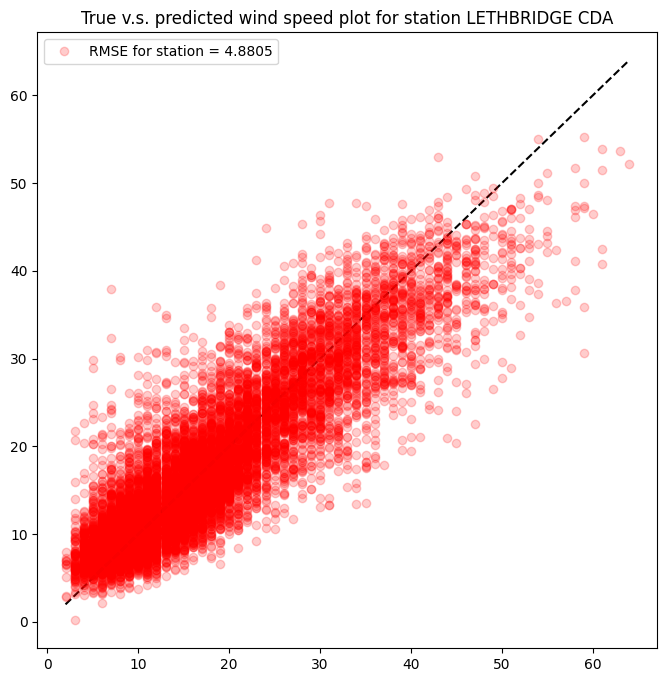

177/358 [=============>................] - ETA: 0s

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


358/358 [==============================] - 0s 840us/step


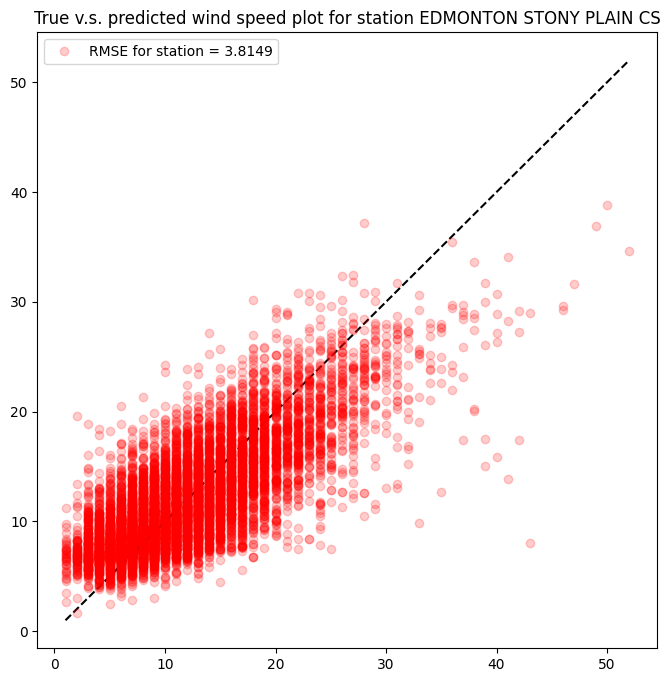

205/358 [================>.............] - ETA: 0s

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


358/358 [==============================] - 0s 681us/step


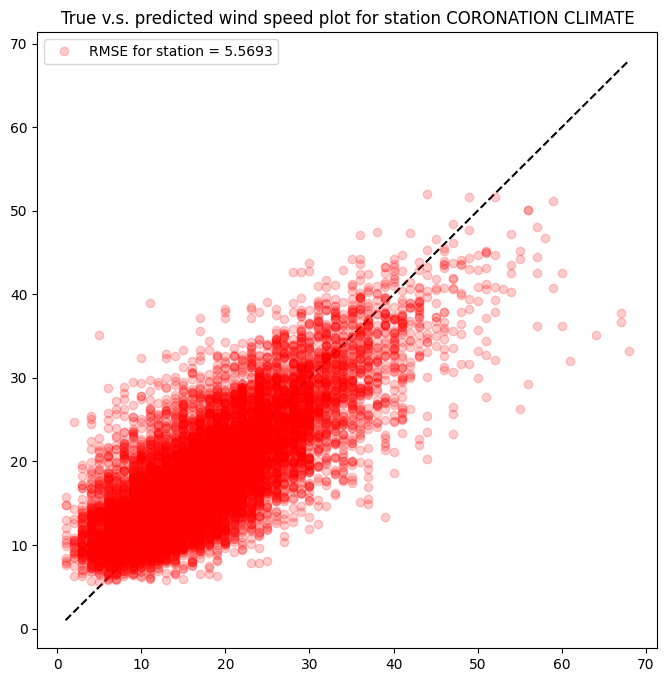

196/358 [===============>..............] - ETA: 0s

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


358/358 [==============================] - 0s 747us/step


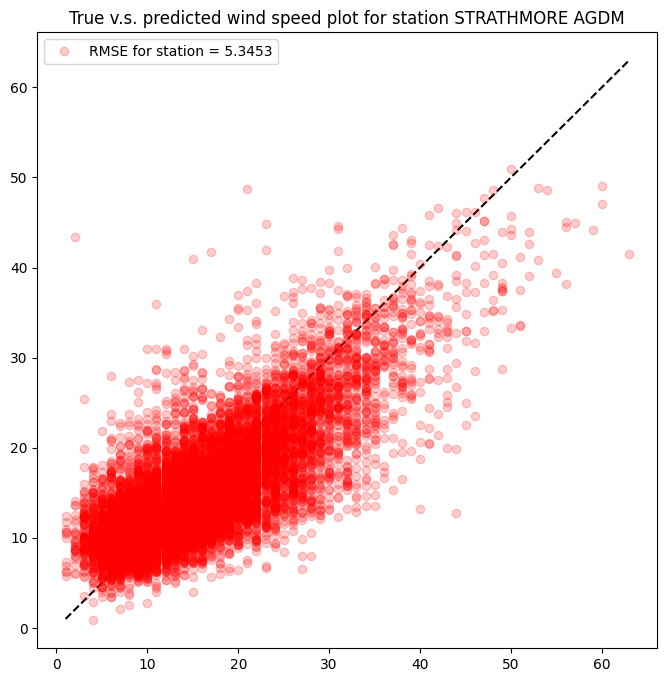

191/358 [===============>..............] - ETA: 0s

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


358/358 [==============================] - 0s 755us/step


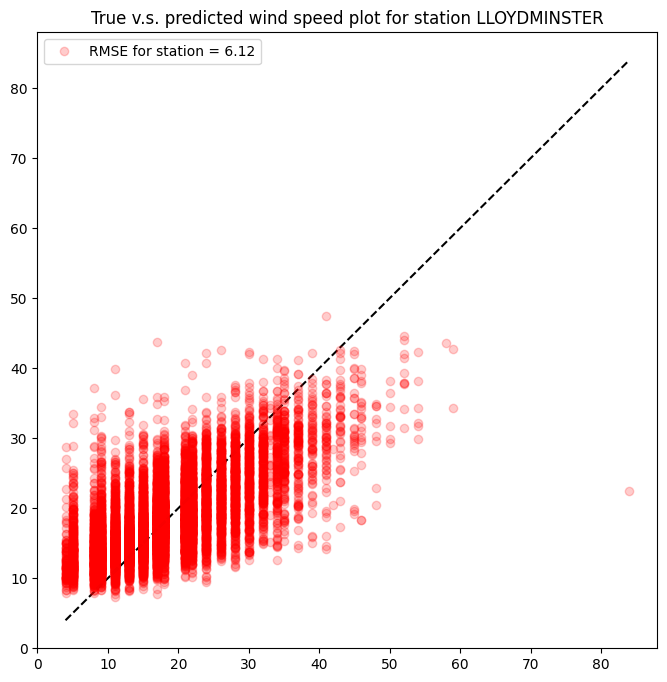

240/358 [===================>..........] - ETA: 0s

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


358/358 [==============================] - 0s 604us/step


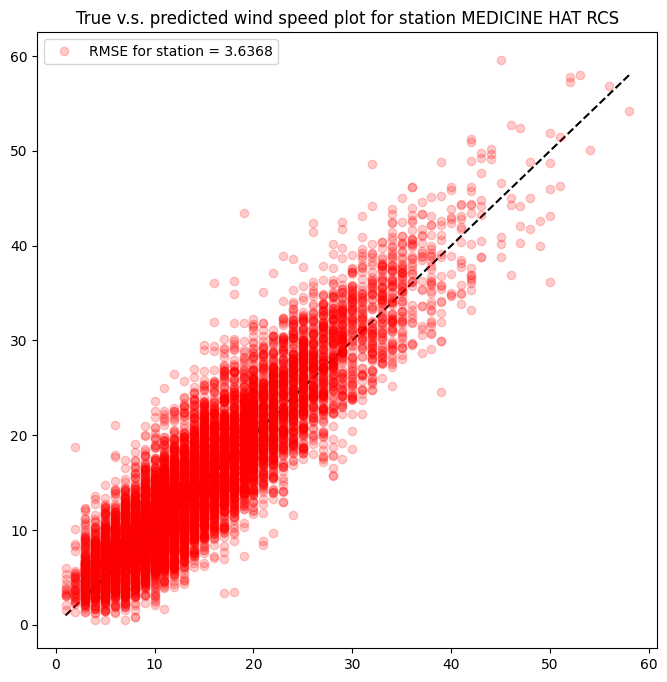

195/358 [===============>..............] - ETA: 0s

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


358/358 [==============================] - 0s 782us/step


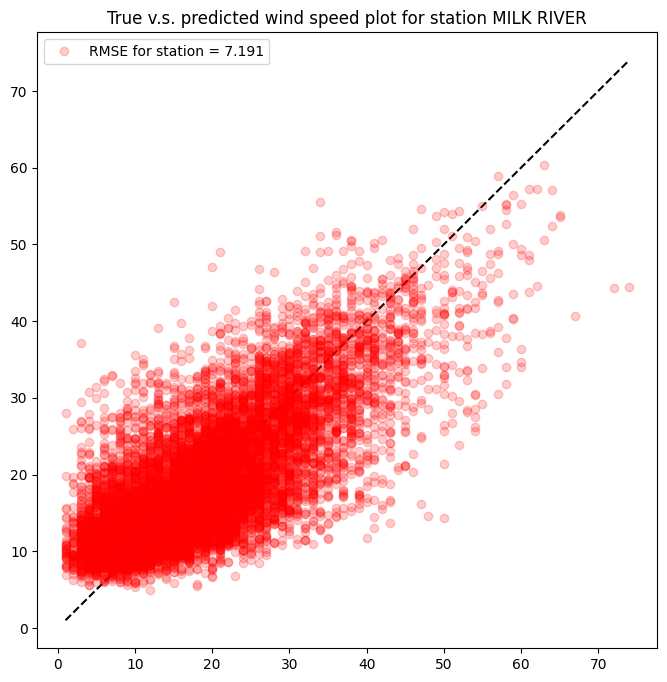

200/358 [===============>..............] - ETA: 0s

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


358/358 [==============================] - 0s 747us/step


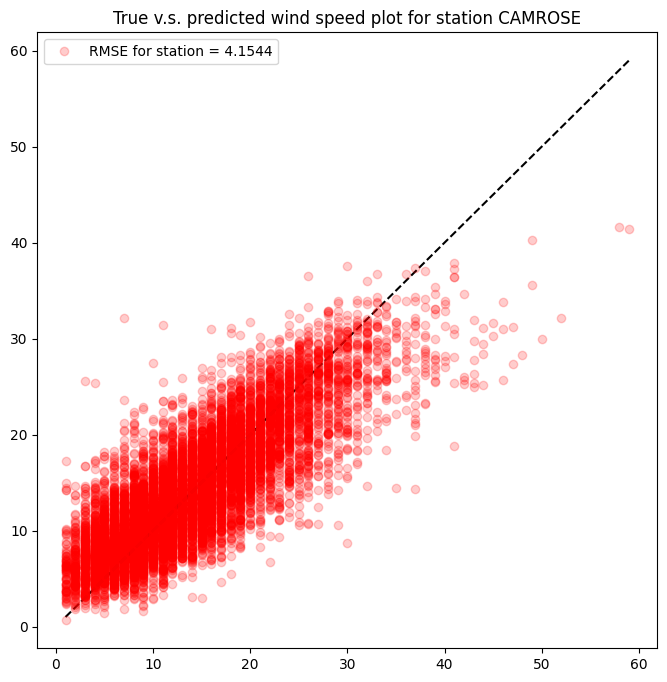

190/358 [==============>...............] - ETA: 0s

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


358/358 [==============================] - 0s 801us/step


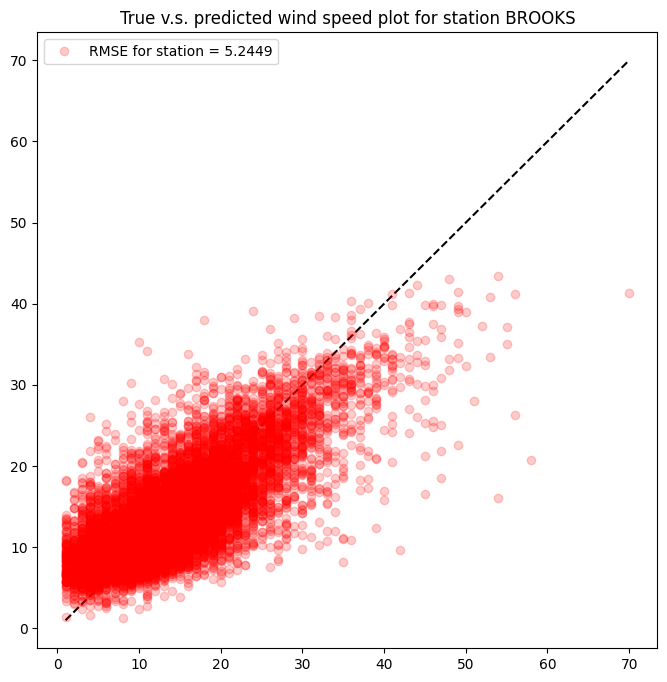

182/358 [==============>...............] - ETA: 0s

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


358/358 [==============================] - 0s 755us/step


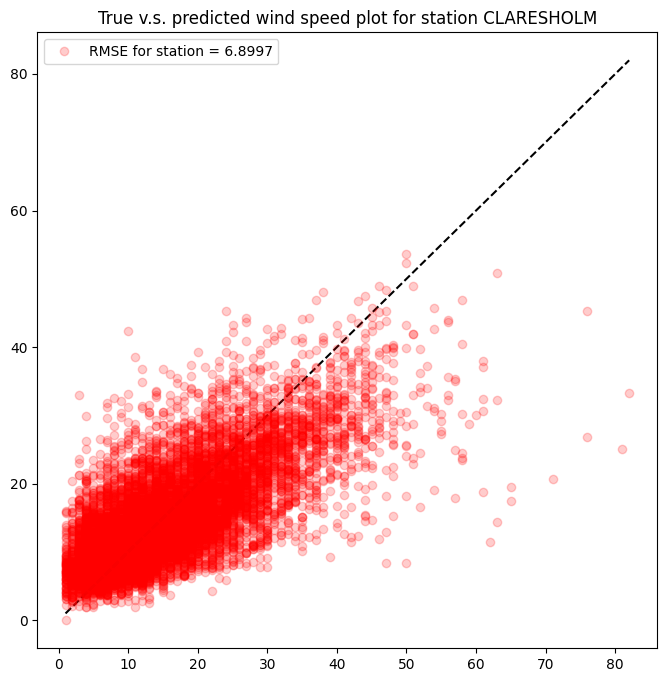

185/358 [==============>...............] - ETA: 0s

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


358/358 [==============================] - 0s 781us/step


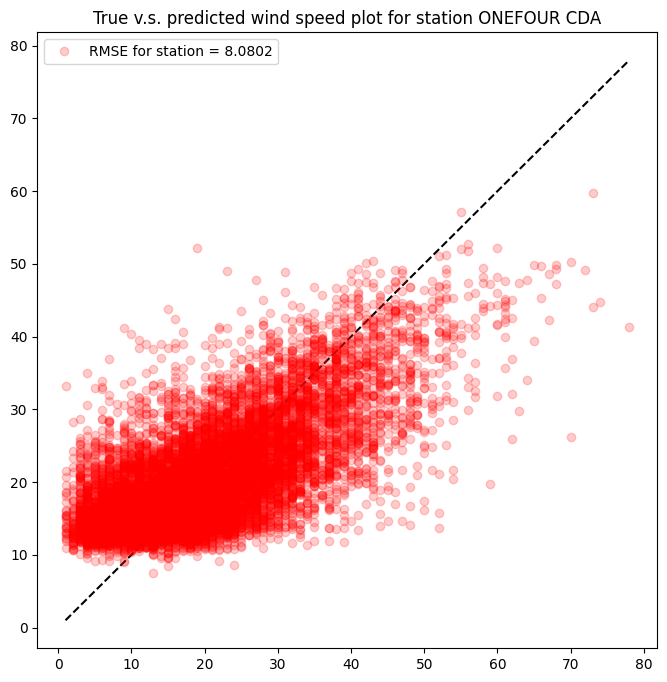

181/358 [==============>...............] - ETA: 0s

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


358/358 [==============================] - 0s 849us/step


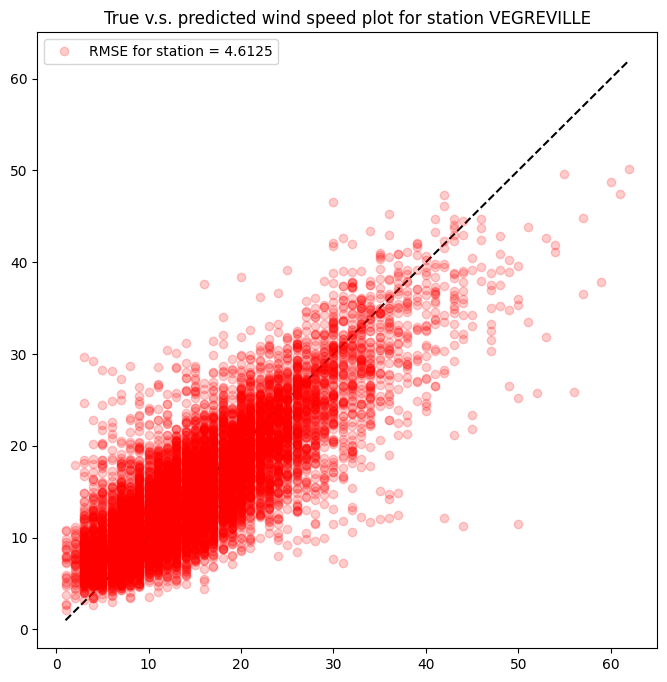

209/358 [================>.............] - ETA: 0s

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


358/358 [==============================] - 0s 687us/step


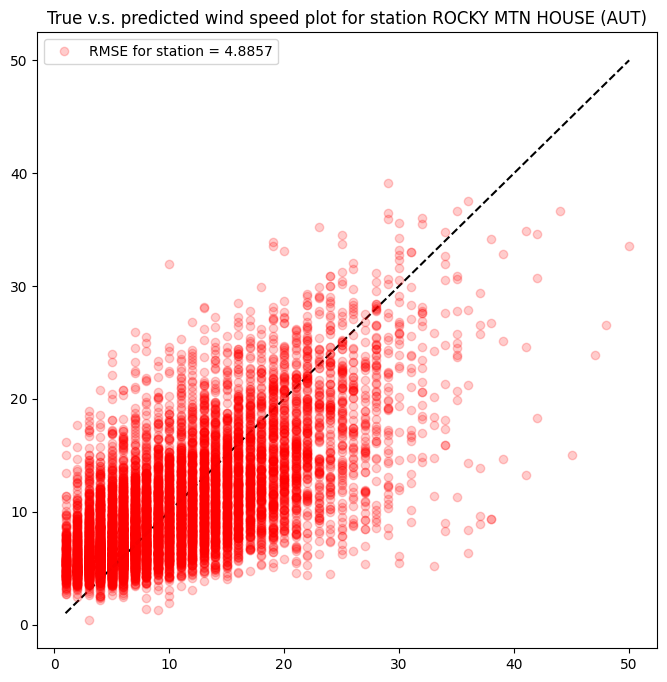

203/358 [================>.............] - ETA: 0s

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


358/358 [==============================] - 0s 663us/step


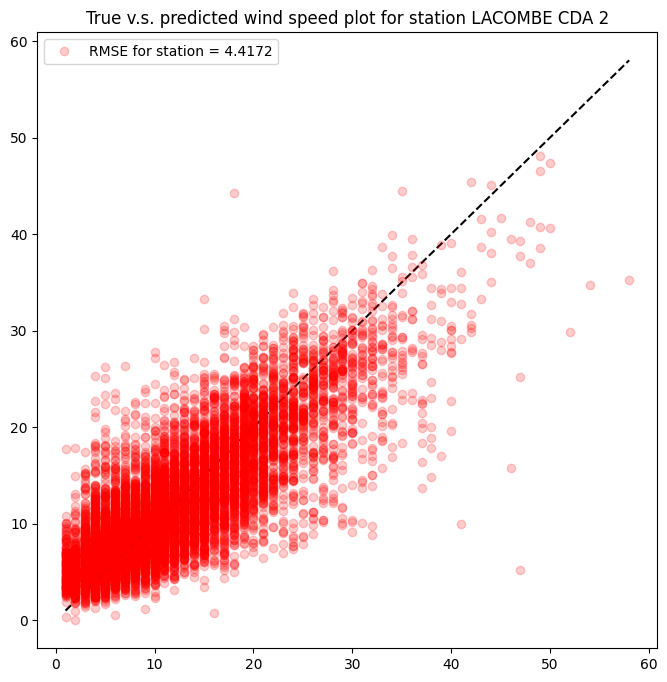

239/358 [===================>..........] - ETA: 0s

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


358/358 [==============================] - 0s 605us/step


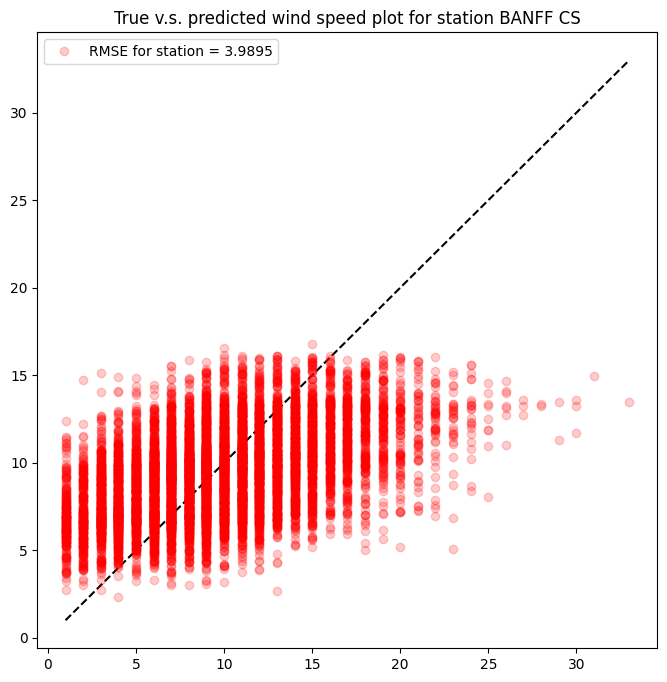

193/358 [===============>..............] - ETA: 0s

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


358/358 [==============================] - 0s 791us/step


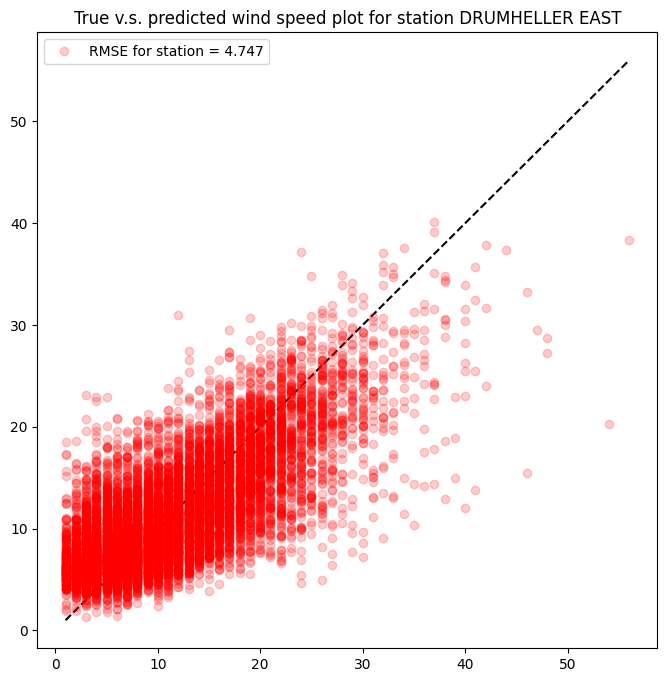

199/358 [===============>..............] - ETA: 0s

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


358/358 [==============================] - 0s 736us/step


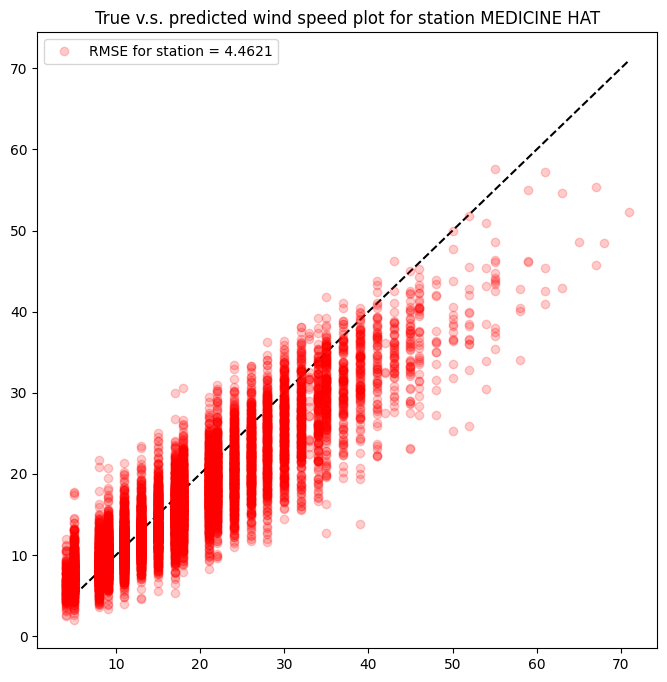

192/358 [===============>..............] - ETA: 0s

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


358/358 [==============================] - 0s 804us/step


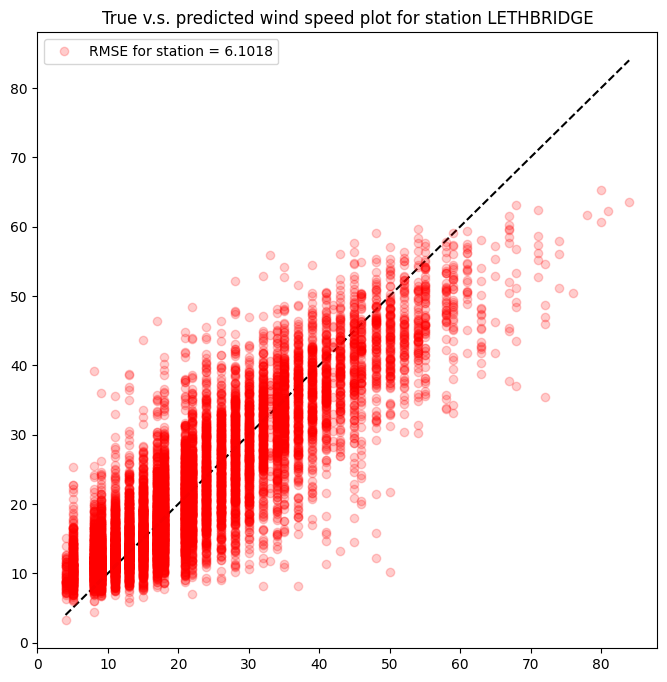

209/358 [================>.............] - ETA: 0s

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


358/358 [==============================] - 0s 662us/step


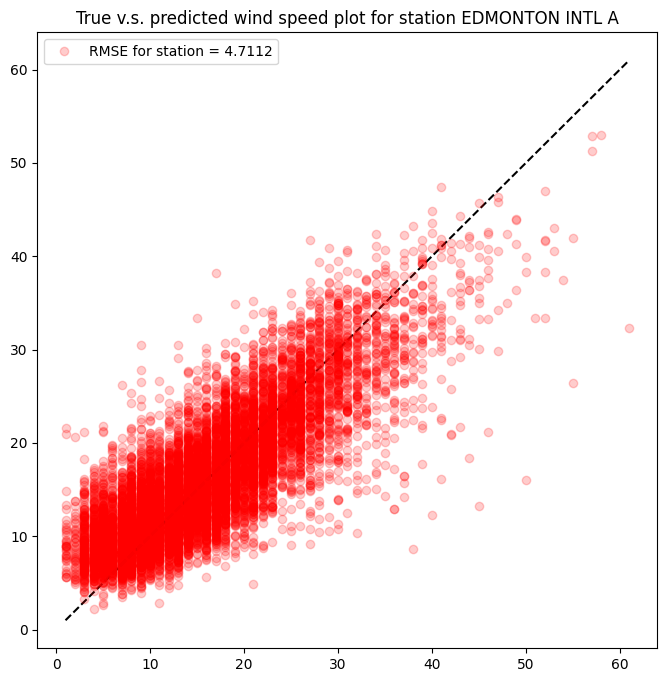

190/358 [==============>...............] - ETA: 0s

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


358/358 [==============================] - 0s 759us/step


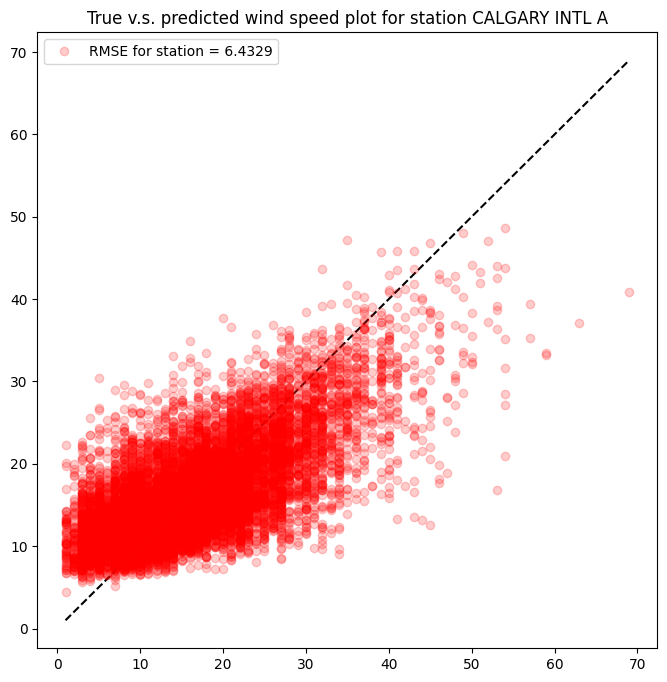

In [25]:
# plots for testing data
prediction_per_stations = []
test_x = []
test_y = []

for station in stations_to_test:
    features, target = Data_utils.generate_data(
        test_data, 
        station, 
        9, 
        100000, 
        0
    )
    x = np.array(features)
    x = scaler.transform(x)
    y = np.array(target)
    
    test_x.append(x)
    test_y.append(y)
    prediction = np.array(neural_network_model.predict(x)).flatten()
    
    plot_prediction_error(y, prediction, station)
    
    prediction_per_stations.append({station : prediction})

In [40]:
test_x = np.array(test_x)
test_x = test_x.reshape(-1, test_x.shape[-1])
test_y = np.array(test_y)
test_y = test_y.flatten()

In [42]:
predict_test = neural_network_model.evaluate(test_x, test_y)

7157/7157 [==============================] - 7s 988us/step - loss: 29.0921 - root_mean_squared_error: 5.3937


In [43]:
predict_test = neural_network_model.predict(test_x)
r2 = r2_score(test_y, predict_test)
print(r2)

7157/7157 [==============================] - 4s 514us/step
0.6664769249040547
